# Hyperparameter Tuning by Randomized-Search


In the previous notebook, we showed how to use a grid-search approach to search for the best hyperparameters maximizing the generalization performance of a predictive model.

However, a grid-search approach has limitations. It does not scale when the number of parameters to tune is increasing. Also, the grid will impose a regularity during the search which might be problematic.

In this notebook, we will present another method to tune hyperparameters called randomized search.

## Our Predictive Model

Let us reload the dataset as we did previously:

In [2]:
import pandas as pd
from sklearn import set_config

set_config(display='diagram')

In [3]:
df = pd.read_csv('data/adult-census.csv')
df.head()

age   workclass  fnlwgt      education  education-num       marital-status  \
0   25     Private  226802           11th              7        Never-married   
1   38     Private   89814        HS-grad              9   Married-civ-spouse   
2   28   Local-gov  336951     Assoc-acdm             12   Married-civ-spouse   
3   44     Private  160323   Some-college             10   Married-civ-spouse   
4   18           ?  103497   Some-college             10        Never-married   

           occupation relationship    race      sex  capital-gain  \
0   Machine-op-inspct    Own-child   Black     Male             0   
1     Farming-fishing      Husband   White     Male             0   
2     Protective-serv      Husband   White     Male             0   
3   Machine-op-inspct      Husband   Black     Male          7688   
4                   ?    Own-child   White   Female             0   

   capital-loss  hours-per-week  native-country   class  
0             0              40   United-States   <=50K  
1             0              50   United-States   <=50K  
2             0              40   United-States    >50K  
3             0              40   United-States    >50K  
4             0              30   United-States   <=50K

We separate the column containing the target from the rest of the data.

In [5]:
target = df['class']
data = df.drop(columns=['class', 'education-num'])

Once the dataset is loaded, we split it into a training and testing sets.

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
data_train, data_test, target_train, target_test = train_test_split(data,
                                                                   target,
                                                                   random_state=42)

We will create the same predictive pipeline as seen in the grid-search section.

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_selector as selector

In [9]:
categorical_columns_selector = selector(dtype_include='object')
categorical_columns = categorical_columns_selector(data)
categorical_preprocessor = OrdinalEncoder(handle_unknown='use_encoded_value',
                                         unknown_value=-1)
preprocessor = ColumnTransformer([
    ('cat-preprocessor', categorical_preprocessor, categorical_columns)],
    remainder='passthrough', sparse_threshold=0)

In [10]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

In [11]:
model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", HistGradientBoostingClassifier(random_state=42, max_leaf_nodes=4)),
])

model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('cat-preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier',
                 HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                random_state=42))])

## Tuning Using a Randomized-Search

With the `GridSearchCV` estimator, the parameters need to be specified explicitly. We already mentioned that exploring a large number of values for different parameters will be quickly untractable.

Instead, we can randomly generate the parameter candidates. Indeed, such approach avoids the regularity of the grid. Hence, adding more evaluations can increase the resolution in each direction. This is the case in the frequent situation where the choice of some hyperparameters is not very important, as for hyperparameter 2 in the figure below.

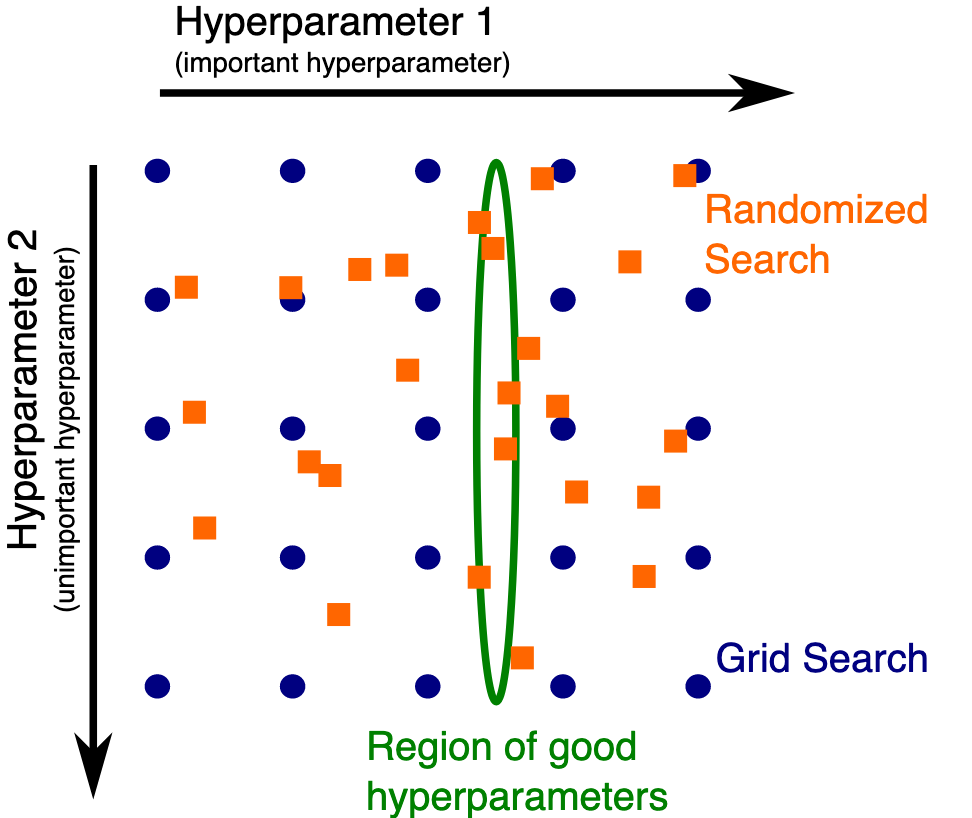

Indeed, the number of evaluation points need to be divided across the two different hyperparameters. With a grid, the danger is that the region of good hyperparamerters fall between the line of the grid: this region is aligned with the grid given that hyperparameter 2 has a weak influence. Rather, stochastic search will sample hyperparameter 1 independently from hyperparameter 2 and find the optimal region.